In [1]:
!odsc data-catalog config --authentication resource_principal --metastore <metastore_id>

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `odsc data-catalog config --authentication resource_principal --metastore <metastore_id>'


Oracle Data Science service sample notebook.

Copyright (c) 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

***

# <font color="red">Schema enforcement and schema evolution</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:
---
Managing many datasets, data-sources and transformations for machine learning is complex and costly. Poorly cleaned data, data issues, bugs in transformations, data drift and training serving skew all leads to increased model development time and worse model performance. Here, feature store is well positioned to solve many of the problems since it provides a centralised way to transform and access data for training and serving time and helps defines a standardised pipeline for ingestion of data and querying of data. This notebook demonstrates how to use feature store within a long lasting [Oracle Cloud Infrastructure Data Flow](https://docs.oracle.com/en-us/iaas/data-flow/using/home.htm) cluster.

Compatible conda pack: [PySpark 3.2 and Feature store](https://docs.oracle.com/iaas/data-science/using/conda-pyspark-fam.htm) for CPU on Python 3.8

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/overview-roles.png"  />
</div>

## Contents:

- <a href="#concepts">1. Introduction</a>
- <a href='#pre-requisites'>1. Pre-requisites</a>
    - <a href='#policies'>2.1 Policies</a>
    - <a href='#prerequisites_authentication'>2.2 Authentication</a>
    - <a href='#prerequisites_variables'>2.3 Variables</a>
- <a href='#schema'>3. Schema enforcement and schema evolution</a>
    - <a href='#data_exploration'>3.1. Exploration of data in feature store</a>
    - <a href='#load_featuregroup'>3.2. Create feature store logical entities</a>
    - <a href='#schema_enforcement'>3.3. Schema enforcement</a>
    - <a href='#ingestion_modes'>3.4. Ingestion Modes</a>
        - <a href='#append'>3.4.1 Append</a>
        - <a href='#overwrite'>3.4.2 Overwrite</a>
        - <a href='#upsert'>3.4.3 Upsert</a>
- <a href='#ref'>4. References</a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

<a id="concepts"></a>
# 1. Introduction

Oracle feature store is a stack based solution that is deployed in the customer enclave using OCI resource manager. Customer can stand up the service with infrastructure in their own tenancy. The service consists of API which are deployed in customer tenancy using resource manager.

The following are some key terms that will help you understand OCI Data Science Feature Store:


* **Feature Vector**: Set of feature values for any one primary/identifier key. Eg. All/subset of features of customer id ‘2536’ can be called as one feature vector.

* **Feature**: A feature is an individual measurable property or characteristic of a phenomenon being observed.

* **Entity**: An entity is a group of semantically related features. The first step a consumer of features would typically do when accessing the feature store service is to list the entities and the entities associated features. Another way to look at it is that an entity is an object or concept that is described by its features. Examples of entities could be customer, product, transaction, review, image, document, etc.

* **Feature Group**: A feature group in a feature store is a collection of related features that are often used together in ml models. It serves as an organizational unit within the feature store for users to manage, version and share features across different ml projects. By organizing features into groups, data scientists and ml engineers can efficiently discover, reuse and collaborate on features reducing the redundant work and ensuring consistency in feature engineering.

* **Feature Group Job**: Feature group job is the execution instance of a feature group. Each feature group job will include validation results and statistics results.

* **Dataset**: A dataset is a collection of feature that are used together to either train a model or perform model inference.

* **Dataset Job**: Dataset job is the execution instance of a dataset. Each dataset job will include validation results and statistics results.

<a id='pre-requisites'></a>
# 2. Pre-requisites

Data Flow Sessions are accessible through the following conda environment:

* **PySpark 3.2, Feature store 1.0 and Data Flow 1.0 (fs_pyspark32_p38_cpu_v1)**

The [Data Catalog Hive Metastore](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm) provides schema definitions for objects in structured and unstructured data assets. The Metastore is the central metadata repository to understand tables backed by files on object storage. You can customize `fs_pyspark32_p38_cpu_v1`, publish it, and use it as a runtime environment for a Data Flow session cluster. The metastore id of hive metastore is tied to feature store construct of feature store service.


<a id='setup_spark-defaults'></a>
### `spark-defaults.conf`

The `spark-defaults.conf` file is used to define the properties that are used by Spark. A templated version is installed when you install a Data Science conda environment that supports PySpark. However, you must update the template so that the Data Catalog metastore can be accessed. You can do this manually. However, the `odsc data-catalog config` commandline tool is ideal for setting up the file because it gathers information about your environment, and uses that to build the file.

The `odsc data-catalog config` command line tool needs the `--metastore` option to define the Data Catalog metastore OCID. No other command line option is needed because settings have default values, or they take values from your notebook session environment. Following are common parameters that you may need to override.

The `--authentication` option sets the authentication mode. It supports resource principal and API keys. The preferred method for authentication is resource principal, which is sent with `--authentication resource_principal`. If you want to use API keys, then use the `--authentication api_key` option. If the `--authentication` isn't specified, API keys are used. When API keys are used, information from the OCI configuration file is used to create the `spark-defaults.conf` file.

Object Storage and Data Catalog are regional services. By default, the region is set to the region your notebook session is running in. This information is taken from the environment variable, `NB_REGION`. Use the `--region` option to override this behavior.

The default location of the `spark-defaults.conf` file is `/home/datascience/spark_conf_dir` as defined in the `SPARK_CONF_DIR` environment variable. Use the `--output` option to define the directory where to write the file.

You need to determine what settings are appropriate for your configuration. However, the following works for most configurations and is run in a terminal window.

```bash
odsc data-catalog config --authentication resource_principal --metastore <metastore_id>
```
For more assistance, use the following command in a terminal window:

```bash
odsc data-catalog config --help
```

<a id='setup_session'></a>
### Session Setup

The notebook makes connections to the Data Catalog metastore and Object Storage. In the next cell, specify the bucket URI to act as the data warehouse. Use the `warehouse_uri` variable with the `oci://<bucket_name>@<namespace_name>/<key>` format. Update the variable `metastore_id` with the OCID of the Data Catalog metastore.

<a id='policies'></a>
### 2.1. Policies
This section covers the creation of dynamic groups and policies needed to use the service.

* [Data Flow Policies](https://docs.oracle.com/iaas/data-flow/using/policies.htm/)
* [Data Catalog Metastore Required Policies](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm)
* [Getting Started with Data Flow](https://docs.oracle.com/iaas/data-flow/using/dfs_getting_started.htm)
* [About Data Science Policies](https://docs.oracle.com/iaas/data-science/using/policies.htm)

<a id="prerequisites_authentication"></a>
### 2.2. Authentication
The [Oracle Accelerated Data Science SDK (ADS)](https://docs.oracle.com/iaas/tools/ads-sdk/latest/index.html) controls the authentication mechanism with the notebook cluster.<br>
To setup authentication use the ```ads.set_auth("resource_principal")``` or ```ads.set_auth("api_key")```.

In [1]:
import ads
ads.set_auth(auth="resource_principal", client_kwargs={"service_endpoint": "https://bi3jfhvilwl7gelzjbv3ovim2m.apigateway.us-ashburn-1.oci.customer-oci.com/20230101"})

<a id="prerequisites_variables"></a>
### 2.3. Variables
To run this notebook, you must provide some information about your tenancy configuration. To create and run a feature store, you must specify a `<compartment_id>` and bucket `<metastore_id>` for offline feature store.

In [2]:
import os

compartment_id = "ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa"
metastore_id = "ocid1.datacatalogmetastore.oc1.iad.amaaaaaabiudgxyap7tizm4gscwz7amu7dixz7ml3mtesqzzwwg3urvvdgua"

<a id="schema"></a>
# 3. Schema enforcement and schema evolution
By default the **PySpark 3.2, Feature store and Data Flow** conda environment includes pre-installed [great-expectations](https://legacy.docs.greatexpectations.io/en/latest/reference/core_concepts/validation.html) and [deeque](https://github.com/awslabs/deequ) libraries. The joining functionality is heavily inspired by the APIs used by Pandas to merge, join or filter DataFrames. The APIs allow you to specify which features to select from which feature group, how to join them and which features to use in join conditions.



In [3]:
import pandas as pd
from ads.feature_store.feature_store import FeatureStore
from ads.feature_store.feature_group import FeatureGroup
from ads.feature_store.model_details import ModelDetails
from ads.feature_store.dataset import Dataset
from ads.feature_store.common.enums import DatasetIngestionMode

from ads.feature_store.feature_group_expectation import ExpectationType
from great_expectations.core import ExpectationSuite, ExpectationConfiguration
from ads.feature_store.feature_store_registrar import FeatureStoreRegistrar

  from .model_deployment_properties import ModelDeploymentProperties

  from .model_deployer import ModelDeployer

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  LooseVersion(pyarrow.__version__) >= LooseVersion("2.0.0")

  if LooseVersion(pd.__version__) >= LooseVersion("0.24"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) >= LooseVersion("1.3.0"):

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore

Implementing implicit na

<a id="data_exploration"></a>
### 3.1. Exploration of data in feature store

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/feature_store_demo.jpg" width="700" height="350" />
</div>

In [4]:
flights_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/flights.csv")[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]
flights_df = flights_df.head(100)
flights_df.head()

  flights_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/flights.csv")[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]



,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,2015,1,1,4,AS,98,ANC,SEA
1,2015,1,1,4,AA,2336,LAX,PBI
2,2015,1,1,4,US,840,SFO,CLT
3,2015,1,1,4,AA,258,LAX,MIA
4,2015,1,1,4,AS,135,SEA,ANC


In [6]:
columns = ['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'LATITUDE', 'LONGITUDE']
airports_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/airports.csv")[columns]
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,31.53552,-84.19447


In [7]:
airlines_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/airlines.csv")
airlines_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


<a id="load_featuregroup"></a>
### 3.2. Create feature store logical entities

#### 3.2.1 Feature Store
Feature store is the top level entity for feature store service

In [8]:
feature_store_resource = (
    FeatureStore().
    with_description("Data consisting of flights").
    with_compartment_id(compartment_id).
    with_display_name("flights details").
    with_offline_config(metastore_id=metastore_id)
)

<a id="create_feature_store"></a>
##### Create Feature Store

Call the ```.create()``` method of the Feature store instance to create a feature store.

In [9]:
feature_store = feature_store_resource.create()
feature_store


kind: featurestore
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Data consisting of flights
  displayName: flights details
  id: EA128EDAE4380286A842064AF466A685
  offlineConfig:
    metastoreId: ocid1.datacatalogmetastore.oc1.iad.amaaaaaabiudgxyap7tizm4gscwz7amu7dixz7ml3mtesqzzwwg3urvvdgua
type: featureStore

#### 3.2.2 Entity
An entity is a group of semantically related features.

In [10]:
entity = feature_store.create_entity(
    display_name="Flight details schema evolution/enforcement",
    description="description for flight details"
)
entity


kind: entity
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: description for flight details
  featureStoreId: EA128EDAE4380286A842064AF466A685
  id: 55EB4FC9F3D8AEE40442046F7B7EE92C
  name: Flight details schema evolution/enforcement
type: entity

<a id="create_feature_group_airport"></a>
#### 3.2.3 Feature Group

Create feature group for airport

In [11]:
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

expectation_suite_airports = ExpectationSuite(
    expectation_suite_name="test_airports_df"
)
expectation_suite_airports.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "IATA_CODE"},
    )
)
expectation_suite_airports.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={"column": "LATITUDE", "min_value": -1.0, "max_value": 1.0},
    )
)

expectation_suite_airports.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={"column": "LONGITUDE", "min_value": -1.0, "max_value": 1.0},
    )
)

{"meta": {}, "expectation_type": "expect_column_values_to_be_between", "kwargs": {"column": "LONGITUDE", "min_value": -1.0, "max_value": 1.0}}

In [12]:
feature_group_airports = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys(["IATA_CODE"])
    .with_name("airport_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(airports_df)
    .with_expectation_suite(
        expectation_suite=expectation_suite_airports,
        expectation_type=ExpectationType.LENIENT,
     )
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023/07/25 10:07:54 NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  arrow_data = [[(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]



In [13]:
feature_group_airports.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 55EB4FC9F3D8AEE40442046F7B7EE92C
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: IATA_CODE
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    - arguments:
        column: LATITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-1
      ruleType: expect_column_values_to_be_between
    - arguments:
        column: LONGITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-2
      ruleType: expect_column_values_to_be_between
    expectationType: LENIENT
    name: test_airports_df
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: EA128EDAE4380286A842064AF466A685
  id: 26DE61A551F8BF29F132FF03B62B3E67
  inputFeatureDetails:
  - featureType: STRING
    name: IATA_CODE
    orderNumber: 1
  - feat

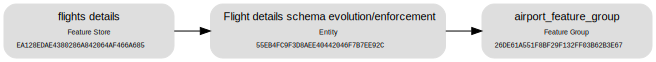

In [14]:
feature_group_airports.show()

In [15]:
feature_group_airports.materialise(airports_df)

Hive Session ID = cdd7eb82-a9e8-4f1b-bdad-93400dab3a3a


INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

INFO:mlm_insights.builder:validating required components
INFO:mlm_insights.builder:required components validated
INFO:mlm_insights.builder.usage:Activating Minimal Insights Usage
INFO:mlm_insights.builder:Generating Runner object
INFO:mlm_insights.builder:Generating workflow request
INFO:mlm_insights.workflow:Fetching engine object
INFO:mlm_insights.workflow:Returning native engine object
INFO:mlm_insights.builder:Running Fugue Workflow
INFO:mlm_insights.workflow:Executing Fugue Workflow


INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9d43f629f0>), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f9d43f6e970>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9d43f6ef70>), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f9d43f6ef30>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9d43f521b0>), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f9d43f52230>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_dat

INFO:mlm_insights.core.sfcs:getting SFCMetaData(klass=<class 'mlm_insights.core.sfcs.distinct_count_sfc.DistinctCountSFC'>, config={}) sfc from sfc meta data
INFO:mlm_insights.core.sfcs:getting SFCMetaData(klass=<class 'mlm_insights.core.sfcs.frequent_items_sfc.FrequentItemsSFC'>, config={}) sfc from sfc meta data
INFO:mlm_insights.core.sfcs:Getting total count of input data
INFO:mlm_insights.core.sfcs:Calculated cardinality = 319.0002519341608 in Distinct count SFC, upper bound = 319.01617937768685, lower bound = 319.0
INFO:mlm_insights.core.metrics:Calculated DistinctCount metric, value: 319
INFO:mlm_insights.core.metrics:Calculated Sum metric, value: -31382.88966
INFO:mlm_insights.core.sfcs:getting SFCMetaData(klass=<class 'mlm_insights.core.sfcs.frequent_items_sfc.FrequentItemsSFC'>, config={}) sfc from sfc meta data
INFO:mlm_insights.core.sfcs:Getting list of all frequent items
INFO:mlm_insights.core.metrics:Calculated IsQuasiConstantFeature metric, value: True
INFO:mlm_insights.c

<a id="schema_enforcement"></a>
### 3.3. Schema enforcement

Schema enforcement, also known as schema validation, is a safeguard in Delta Lake that ensures data quality by rejecting writes to a table that do not match the table's schema. Like the front desk manager at a busy restaurant that only accepts reservations, it checks to see whether each column in data inserted into the table is on its list of expected columns (in other words, whether each one has a "reservation"), and rejects any writes with columns that aren't on the list.

In [17]:
columns = ['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'LATITUDE', 'LONGITUDE', 'COUNTRY']
airports_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/airports.csv")[columns]
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,LATITUDE,LONGITUDE,COUNTRY
0,ABE,Lehigh Valley International Airport,Allentown,PA,40.65236,-75.44040,USA
1,ABI,Abilene Regional Airport,Abilene,TX,32.41132,-99.68190,USA
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,35.04022,-106.60919,USA
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,45.44906,-98.42183,USA
4,ABY,Southwest Georgia Regional Airport,Albany,GA,31.53552,-84.19447,USA


In [18]:
feature_group_airports.with_schema_details_from_dataframe(airports_df)
feature_group_airports.update()

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  arrow_data = [[(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]




kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 55EB4FC9F3D8AEE40442046F7B7EE92C
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: IATA_CODE
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    - arguments:
        column: LATITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-1
      ruleType: expect_column_values_to_be_between
    - arguments:
        column: LONGITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-2
      ruleType: expect_column_values_to_be_between
    expectationType: LENIENT
    name: test_airports_df
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: EA128EDAE4380286A842064AF466A685
  id: 26DE61A551F8BF29F132FF03B62B3E67
  inputFeatureDetails:
  - featureType: STRING
    name: IATA_CODE
    orderNumber: 1
  - feat

In [19]:
feature_group_airports.materialise(airports_df)

INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

<a id="schema_evolution"></a>
### 3.4. Schema evolution

Schema evolution is a feature that allows users to easily change a table's current schema to accommodate data that is changing over time. Most commonly, it's used when performing an append or overwrite operation, to automatically adapt the schema to include one or more new columns.

In [20]:
from ads.feature_store.feature_option_details import FeatureOptionDetails
feature_option_details = FeatureOptionDetails().with_feature_option_write_config_details(merge_schema=True)

In [21]:
feature_group_airports.materialise(
    input_dataframe=airports_df,
    feature_option_details=feature_option_details
)

INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

INFO:mlm_insights.builder:validating required components
INFO:mlm_insights.builder:required components validated
INFO:mlm_insights.builder.usage:Activating Minimal Insights Usage
INFO:mlm_insights.builder:Generating Runner object
INFO:mlm_insights.builder:Generating workflow request
INFO:mlm_insights.workflow:Fetching engine object
INFO:mlm_insights.workflow:Returning native engine object
INFO:mlm_insights.builder:Running Fugue Workflow
INFO:mlm_insights.workflow:Executing Fugue Workflow
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9d440f85f0>), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f9d440f87b0>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9d440f8cf0>), '4cd1d3704778a196571a6c83581854cc': D

In [22]:
feature_group_airports


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 55EB4FC9F3D8AEE40442046F7B7EE92C
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: IATA_CODE
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    - arguments:
        column: LATITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-1
      ruleType: expect_column_values_to_be_between
    - arguments:
        column: LONGITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-2
      ruleType: expect_column_values_to_be_between
    expectationType: LENIENT
    name: test_airports_df
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: EA128EDAE4380286A842064AF466A685
  id: 26DE61A551F8BF29F132FF03B62B3E67
  inputFeatureDetails:
  - featureType: STRING
    name: IATA_CODE
    orderNumber: 1
  - feat

<a id="ingestion_modes"></a>
### 3.5. Ingestion modes

<a id="append"></a>
#### 3.5.1. Append

In ``append`` mode, new data is added to the existing table. If the table already exists, the new data is appended to it, extending the dataset. This mode is suitable for scenarios where you want to continuously add new records without modifying or deleting existing data. It preserves the existing data and only appends the new data to the end of the table.

In [23]:
from ads.feature_store.feature_group_job import IngestionMode
feature_group_airports.materialise(airports_df, ingestion_mode=IngestionMode.APPEND)

INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

INFO:mlm_insights.builder:validating required components
INFO:mlm_insights.builder:required components validated
INFO:mlm_insights.builder.usage:Activating Minimal Insights Usage
INFO:mlm_insights.builder:Generating Runner object
INFO:mlm_insights.builder:Generating workflow request
INFO:mlm_insights.workflow:Fetching engine object
INFO:mlm_insights.workflow:Returning native engine object
INFO:mlm_insights.builder:Running Fugue Workflow
INFO:mlm_insights.workflow:Executing Fugue Workflow
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9d440e0ef0>), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f9d440e05f0>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9d440f5230>), '4cd1d3704778a196571a6c83581854cc': D

<a id="overwrite"></a>
#### 3.5.2. Overwrite
In ``overwrite`` mode, the existing table is replaced entirely with the new data being saved. If the table already exists, it will be dropped and a new table will be created with the new data. This mode is useful when you want to completely refresh the data in the table with the latest data, discarding any previous records.

In [24]:
from ads.feature_store.feature_group_job import IngestionMode
feature_group_airports.materialise(airports_df, ingestion_mode=IngestionMode.OVERWRITE)

INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

INFO:mlm_insights.builder:validating required components
INFO:mlm_insights.builder:required components validated
INFO:mlm_insights.builder.usage:Activating Minimal Insights Usage
INFO:mlm_insights.builder:Generating Runner object
INFO:mlm_insights.builder:Generating workflow request
INFO:mlm_insights.workflow:Fetching engine object
INFO:mlm_insights.workflow:Returning native engine object
INFO:mlm_insights.builder:Running Fugue Workflow
INFO:mlm_insights.workflow:Executing Fugue Workflow
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9d44159cb0>), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f9d44159a30>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9d441301b0>), '4cd1d3704778a196571a6c83581854cc': D

<a id="upsert"></a>
#### 3.5.3. Upsert
``Upsert`` mode, also known as ``merge`` mode, is used to update existing records in the table based on a primary key or a specified condition. If a record with the same key exists, it will be updated with the new data; otherwise, a new record will be inserted. This mode is useful for maintaining and synchronizing data between the source and destination tables while avoiding duplicates.

In [25]:
from ads.feature_store.feature_group_job import IngestionMode
feature_group_airports.materialise(airports_df, ingestion_mode=IngestionMode.UPSERT)

INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

INFO:mlm_insights.builder:validating required components
INFO:mlm_insights.builder:required components validated
INFO:mlm_insights.builder.usage:Activating Minimal Insights Usage
INFO:mlm_insights.builder:Generating Runner object
INFO:mlm_insights.builder:Generating workflow request
INFO:mlm_insights.workflow:Fetching engine object
INFO:mlm_insights.workflow:Returning native engine object
INFO:mlm_insights.builder:Running Fugue Workflow
INFO:mlm_insights.workflow:Executing Fugue Workflow
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9d43ff4ab0>), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f9d442171f0>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9d4404bd30>), '4cd1d3704778a196571a6c83581854cc': D

<a id="history"></a>
### 3.6. History
You can call the ``history()`` method of the FeatureGroup instance to show history of the feature group.

In [26]:
feature_group_airports.history().toPandas()

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  if LooseVersion(pa.__version__) < LooseVersion("2.0.0"):

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):



,version,timestamp,userId,userName,operation,operationParameters,job,notebook,clusterId,readVersion,isolationLevel,isBlindAppend,operationMetrics,userMetadata,engineInfo
0,4,2023-07-25 10:11:15,None,None,MERGE,"{'predicate': '(target_delta_table.IATA_CODE = source_delta_table.IATA_CODE)', 'matchedPredicates': '[{""actionType"":""update""}]', 'notMatchedPredicates': '[{""actionType"":""insert""}]'}",None,None,None,3.0,Serializable,False,"{'numTargetRowsCopied': '0', 'numTargetRowsDeleted': '0', 'numTargetFilesAdded': '1', 'executionTimeMs': '5340', 'numTargetRowsInserted': '0', 'scanTimeMs': '2694', 'numTargetRowsUpdated': '322', 'numOutputRows': '322', 'numTargetChangeFilesAdded': '0', 'numSourceRows': '322', 'numTargetFilesRemoved': '2', 'rewriteTimeMs': '2443'}",None,Apache-Spark/3.2.1 Delta-Lake/2.0.1
1,3,2023-07-25 10:10:51,None,None,CREATE OR REPLACE TABLE AS SELECT,"{'isManaged': 'true', 'description': None, 'partitionBy': '[]', 'properties': '{}'}",None,None,None,2.0,Serializable,False,"{'numFiles': '2', 'numOutputRows': '322', 'numOutputBytes': '20732'}",None,Apache-Spark/3.2.1 Delta-Lake/2.0.1
2,2,2023-07-25 10:10:28,None,None,WRITE,"{'mode': 'Append', 'partitionBy': '[]'}",None,None,None,1.0,Serializable,True,"{'numFiles': '2', 'numOutputRows': '322', 'numOutputBytes': '20732'}",None,Apache-Spark/3.2.1 Delta-Lake/2.0.1
3,1,2023-07-25 10:10:13,None,None,CREATE OR REPLACE TABLE AS SELECT,"{'isManaged': 'true', 'description': None, 'partitionBy': '[]', 'properties': '{}'}",None,None,None,0.0,Serializable,False,"{'numFiles': '2', 'numOutputRows': '322', 'numOutputBytes': '20732'}",None,Apache-Spark/3.2.1 Delta-Lake/2.0.1
4,0,2023-07-25 10:09:13,None,None,CREATE OR REPLACE TABLE AS SELECT,"{'isManaged': 'true', 'description': None, 'partitionBy': '[]', 'properties': '{}'}",None,None,None,NaN,Serializable,False,"{'numFiles': '2', 'numOutputRows': '322', 'numOutputBytes': '20174'}",None,Apache-Spark/3.2.1 Delta-Lake/2.0.1


<a id="preview"></a>
### 3.6. Preview

You can call the ``preview()`` method of the FeatureGroup instance to preview the feature group.

The ``.preview()`` method takes the following optional parameter:

- timestamp: date-time. Commit timestamp for feature group
- version_number: int. Version number for feature group
- row_count: int. Defaults to 10. Total number of row to return

In [27]:
feature_group_airports.preview().show()

+---------+--------------------+-------------+-----+--------+----------+-------+
|IATA_CODE|             AIRPORT|         CITY|STATE|LATITUDE| LONGITUDE|COUNTRY|
+---------+--------------------+-------------+-----+--------+----------+-------+
|      ABE|Lehigh Valley Int...|    Allentown|   PA|40.65236|  -75.4404|    USA|
|      ABI|Abilene Regional ...|      Abilene|   TX|32.41132|  -99.6819|    USA|
|      ABQ|Albuquerque Inter...|  Albuquerque|   NM|35.04022|-106.60919|    USA|
|      ABR|Aberdeen Regional...|     Aberdeen|   SD|45.44906| -98.42183|    USA|
|      ABY|Southwest Georgia...|       Albany|   GA|31.53552| -84.19447|    USA|
|      ACK|Nantucket Memoria...|    Nantucket|   MA|41.25305| -70.06018|    USA|
|      ACT|Waco Regional Air...|         Waco|   TX|31.61129| -97.23052|    USA|
|      ACV|      Arcata Airport|Arcata/Eureka|   CA|40.97812|-124.10862|    USA|
|      ACY|Atlantic City Int...|Atlantic City|   NJ|39.45758| -74.57717|    USA|
|      ADK|        Adak Airp

<a id='ref'></a>
# References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)